In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import random
import matplotlib
from matplotlib import pyplot as plt
import statistics
from pandas import DataFrame
from datetime import datetime
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras import backend as K
#import keras.backend.tensorflow_backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from os.path import basename
#import seaborn as sns
# from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam




# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8008483763510435111
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9957640644615519075
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1978220958027076894
physical_device_desc: "device: 1, name: TITAN RTX, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


In [3]:
workdir = "D://ResNetIC50//Dataset//MEYODC-6K"

In [4]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]

dataset = np.load(workdir + "//MEYODC6K_dataset.npz") # input file
ss0 = np.load(workdir + '//MEYODC6K_dataset_r0.npz') # split for training and test

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# # In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,300):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

0 21


In [8]:
x.shape

(6050, 79724)

In [9]:
training_image_array.shape

(5445, 79724)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
# img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
#input_shape = (img_rows, img_cols, 1)

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5445, 79724, 1) (5445,) (605, 79724, 1) (605,)


In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (5445, 79724, 1)
5445 train samples
605 test samples


In [15]:
training_image_array.shape

(5445, 79724)

In [16]:
# In[10]:
with tf.device('/GPU:0'):
    inputs = Input(shape=(train_X.shape[1],1),name='inputs')

    x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
    x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
#     y = x
    x = Activation('tanh')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)
    
    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

#     x = AveragePooling1D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=2048, name='dense1'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout1') (x)
    x = Activation('relu')(x)

#    x = Reshape((300,1))(x)

#    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = BatchNormalization()(x)

    x = Dense(units=1024, name='dense5'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout5') (x)
    x = Activation('relu')(x)

    x = Dense(units=512, name='dense6'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout6') (x)
    x = Activation('relu')(x)

    x = Dense(units=1024, name='dense7'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout7') (x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Dense(units=512, name='dense8'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout8') (x)
    x = Activation('relu')(x)
    
    x = Dense(units=256, name='dense9'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout9') (x)
    x = Activation('relu')(x)

    x = Dense(units=128, name='dense10'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout10') (x)
    x = Activation('relu')(x)


    predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
#     predictions = Dense(1, activation='linear', name='predictions')(x)

    

    model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['mse','mae'])


    model.summary()


Model: "Test_v2_DNN20190327"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 79724, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 39862, 16)    64          inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 7972, 16)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7972, 16)     64          max_pooling1d[0][0]              
________________________________________________________________________________

In [17]:
StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with tf.device('/GPU:0'):
    model_train = model.fit(train_X, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2022-02-04 09:34:53.738280
Epoch 1/150
55/55 [==============================] - 19s 255ms/step - loss: 4.7173 - mse: 4.7173 - mae: 1.8169 - val_loss: 7.6752 - val_mse: 7.6752 - val_mae: 2.6172
Epoch 2/150
55/55 [==============================] - 13s 241ms/step - loss: 1.7483 - mse: 1.7483 - mae: 0.9741 - val_loss: 4.8483 - val_mse: 4.8483 - val_mae: 2.0200
Epoch 3/150
55/55 [==============================] - 13s 236ms/step - loss: 1.3404 - mse: 1.3404 - mae: 0.8157 - val_loss: 3.4844 - val_mse: 3.4844 - val_mae: 1.3793
Epoch 4/150
55/55 [==============================] - 13s 234ms/step - loss: 1.0920 - mse: 1.0920 - mae: 0.7278 - val_loss: 3.7991 - val_mse: 3.7991 - val_mae: 1.2016
Epoch 5/150
55/55 [==============================] - 13s 234ms/step - loss: 0.9560 - mse: 0.9560 - mae: 0.6768 - val_loss: 4.0025 - val_mse: 4.0025 - val_mae: 1.1433
Epoch 6/150
55/55 [==============================] - 13s 235ms/step - loss: 0.7828 - mse: 0.7828 - mae: 0.6170 - val_loss: 2.8308 -

Epoch 50/150
55/55 [==============================] - 13s 241ms/step - loss: 0.1606 - mse: 0.1606 - mae: 0.2937 - val_loss: 0.7189 - val_mse: 0.7189 - val_mae: 0.4734
Epoch 51/150
55/55 [==============================] - 13s 240ms/step - loss: 0.1651 - mse: 0.1651 - mae: 0.3001 - val_loss: 0.6929 - val_mse: 0.6929 - val_mae: 0.4754
Epoch 52/150
55/55 [==============================] - 13s 241ms/step - loss: 0.1438 - mse: 0.1438 - mae: 0.2783 - val_loss: 0.6791 - val_mse: 0.6791 - val_mae: 0.4676
Epoch 53/150
55/55 [==============================] - 13s 241ms/step - loss: 0.1730 - mse: 0.1730 - mae: 0.3030 - val_loss: 0.6883 - val_mse: 0.6883 - val_mae: 0.4635
Epoch 54/150
55/55 [==============================] - 13s 241ms/step - loss: 0.1436 - mse: 0.1436 - mae: 0.2790 - val_loss: 0.6657 - val_mse: 0.6657 - val_mae: 0.4683
Epoch 55/150
55/55 [==============================] - 13s 241ms/step - loss: 0.1455 - mse: 0.1455 - mae: 0.2848 - val_loss: 0.6534 - val_mse: 0.6534 - val_mae: 0.459

55/55 [==============================] - 13s 242ms/step - loss: 0.1019 - mse: 0.1019 - mae: 0.2328 - val_loss: 0.6987 - val_mse: 0.6987 - val_mae: 0.4833
Epoch 100/150
55/55 [==============================] - 13s 242ms/step - loss: 0.0979 - mse: 0.0979 - mae: 0.2159 - val_loss: 0.6513 - val_mse: 0.6513 - val_mae: 0.4446
Epoch 101/150
55/55 [==============================] - 13s 243ms/step - loss: 0.0917 - mse: 0.0917 - mae: 0.2171 - val_loss: 0.6518 - val_mse: 0.6518 - val_mae: 0.4458
Epoch 102/150
55/55 [==============================] - 13s 243ms/step - loss: 0.0954 - mse: 0.0954 - mae: 0.2172 - val_loss: 0.7795 - val_mse: 0.7795 - val_mae: 0.4816
Epoch 103/150
55/55 [==============================] - 13s 243ms/step - loss: 0.1414 - mse: 0.1414 - mae: 0.2521 - val_loss: 0.7208 - val_mse: 0.7208 - val_mae: 0.4512
Epoch 104/150
55/55 [==============================] - 13s 244ms/step - loss: 0.1159 - mse: 0.1159 - mae: 0.2408 - val_loss: 0.7863 - val_mse: 0.7863 - val_mae: 0.4760
Epoch 

Epoch 148/150
55/55 [==============================] - 13s 242ms/step - loss: 0.0597 - mse: 0.0597 - mae: 0.1738 - val_loss: 0.6667 - val_mse: 0.6667 - val_mae: 0.4368
Epoch 149/150
55/55 [==============================] - 13s 243ms/step - loss: 0.0550 - mse: 0.0550 - mae: 0.1716 - val_loss: 0.6312 - val_mse: 0.6312 - val_mae: 0.4324
Epoch 150/150
55/55 [==============================] - 13s 242ms/step - loss: 0.0569 - mse: 0.0569 - mae: 0.1742 - val_loss: 0.6292 - val_mse: 0.6292 - val_mae: 0.4461
EndTime : 2022-02-04 10:08:03.955544


In [18]:
import json
workdir = "D://ResNetIC50//Result//MEYODC-6K//ResNet"
# Option 1: Save Weights + Architecture
model.save_weights(workdir+ '//MEYODC6K_ResNet_model_fix_v3.h5')
with open(workdir + '//MEYODC6K_ResNet_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [19]:
# Option 2: Save/Load the Entire Model
# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//MEYODC6K_ResNet_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [20]:
test_eval = model.evaluate(test_X, test_label_array, verbose=1)

19/19 [==============================] - 1s 30ms/step - loss: 0.6292 - mse: 0.6292 - mae: 0.4461


In [21]:
test_eval

[0.6291663646697998, 0.6291663646697998, 0.4460524320602417]

In [22]:
accuracy = model_train.history['mse']
val_accuracy = model_train.history['val_mse']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [23]:
import matplotlib
from matplotlib import pyplot as plt

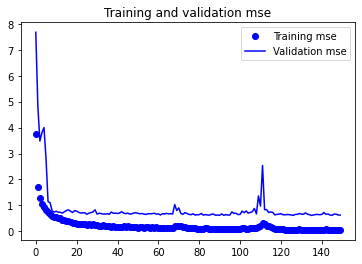

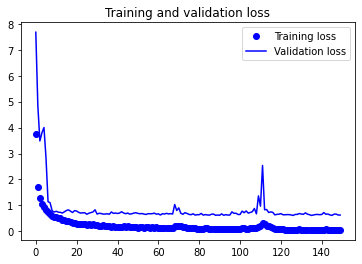

In [24]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes = model.predict(test_X)

In [26]:
predicted_value = predicted_classes

In [27]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [28]:
c.to_csv(workdir + '//MEYODC6K_ResNet_pred_obs_table.csv')

In [29]:
c

,Predicted,Test
0,-1.403599,-2.530241
1,2.103474,2.079442
2,1.407688,2.079442
3,-4.713380,-5.687074
4,2.132904,2.079442
...,...,...
600,0.415272,2.079442
601,2.107003,2.079442
602,2.138407,2.079442
603,-5.245207,-5.046103


In [30]:
predicted_value.shape

(605, 1)

In [31]:
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.8453401278200955, intercept=0.3054432328863391, rvalue=0.9102894132483003, pvalue=3.8552063794096743e-233, stderr=0.015655421693889705, intercept_stderr=0.03306233886757124)

In [32]:
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

0.8214062188425644


In [33]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.7932001205681766


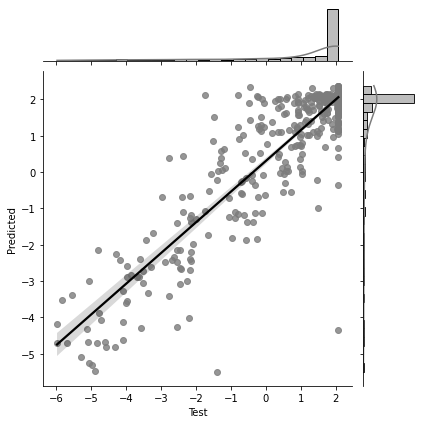

In [34]:
workdir = "D://ResNetIC50//Result//Figure//MEYODC-6K"
import seaborn as sns

g = sns.jointplot(x="Test", y="Predicted", data=c, kind='reg', color='#7C7C7C',
                  joint_kws={'line_kws':{'color':'black'}})
g.savefig(workdir+ '//MEYODC6K_ResNet.png', dpi=300)